In [90]:
import pandas as pd
import numpy as np
import talib as ta
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [44]:
# Configurar parametros (y - anos, mo - meses, wk - semanas, d - dias)

periodo = '15y'
intervalo = '1d'

# Baixar os dados do índice Ibovespa
df = yf.download('^BVSP', period=periodo, interval=intervalo)

[*********************100%***********************]  1 of 1 completed


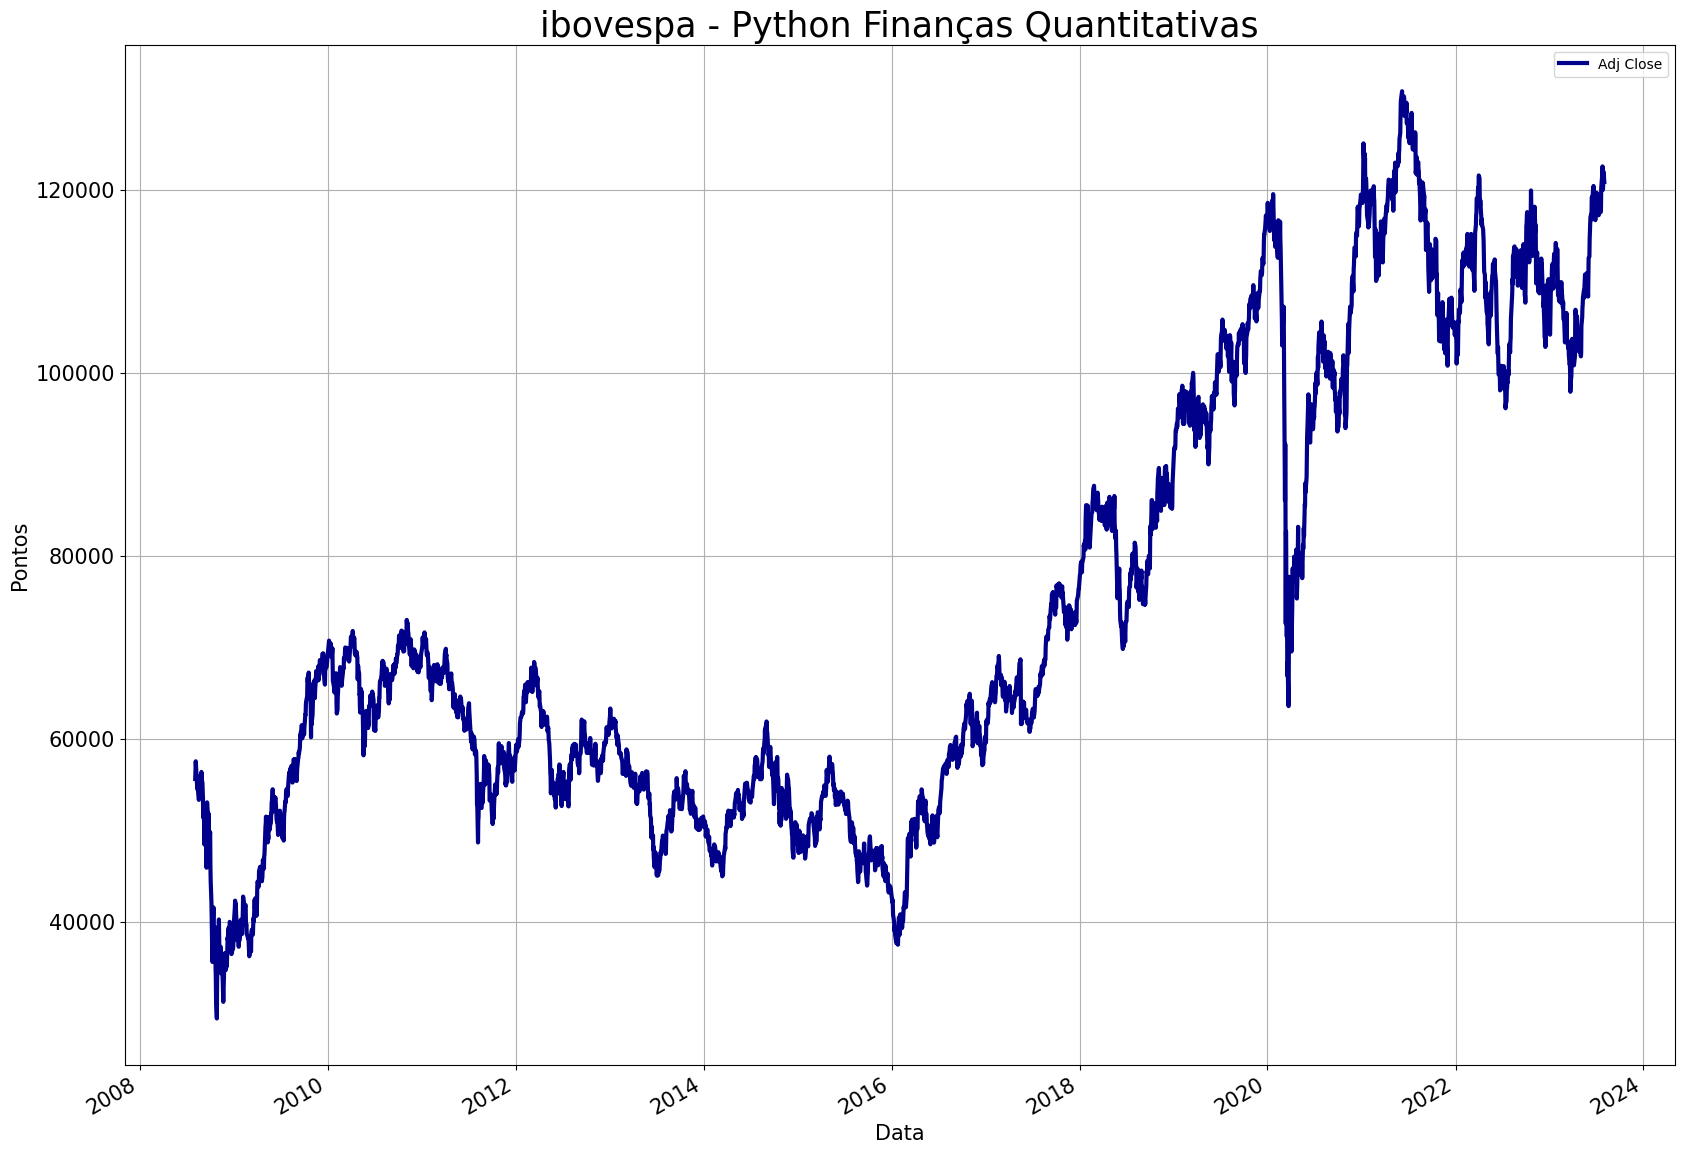

In [45]:
df["Adj Close"].plot(grid = True, figsize = (20, 15), linewidth = 3, fontsize = 15, color = "darkblue")
plt.xlabel("Data"
           , fontsize = 15);
plt.ylabel("Pontos"
           , fontsize = 15);
plt.title("ibovespa - Python Finanças Quantitativas"
           , fontsize = 25);
plt.legend();

In [46]:
def calculate_trix(data, trix_period, ma_period):
    # Certifique-se de que os dados estejam ordenados pela data crescente
    data = data.sort_index(ascending=True)
    
    # Obter os preços de fechamento da série de dados
    close_prices = data['Close'].values
    
    # Calcular o TRIX usando a função TRIX do TA-Lib
    trix = ta.TRIX(close_prices, timeperiod=trix_period)
    
    # Calcular a média móvel do TRIX usando a função SMA (Simple Moving Average) do TA-Lib
    trix_ma = ta.SMA(trix, timeperiod=ma_period)
    
    # Preencher as colunas do TRIX e da média móvel do TRIX com os valores calculados
    data['TRIX'] = trix
    data['TRIX_MA'] = trix_ma
    
    return data

In [47]:
trix_period = 14
ma_period = 5
df_trix = calculate_trix(df, trix_period, ma_period)

In [49]:
# Construcao dos alvos

periodos = 3

# Alvo - Retorno
df_trix.loc[:, "Retorno"] = df_trix["Adj Close"].pct_change(periodos)
df_trix.loc[:, "Alvo"] = df_trix["Retorno"].shift(-periodos)

In [50]:
df.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-08-04,57619.0,57641.0,55367.0,55609.0,55609.0,1148000
2008-08-05,55609.0,56974.0,55609.0,56471.0,56471.0,1402400


In [51]:
# Criando a regra de trade

df_trix.loc[:, "Regra"] = np.where(df_trix.loc[:, 'TRIX'] > df_trix.loc[:, 'TRIX_MA'], 1, 0)

In [52]:
# Aplicando a regra no alvo

df_trix.loc[:, "Trade"] = df_trix.loc[:, "Regra"]*df_trix.loc[:, "Alvo"]

In [53]:
# Calculando o resultado acumulado em juros simples

df_trix.loc[:, "Retorno_Trade_BB"] = df_trix["Trade"].cumsum()

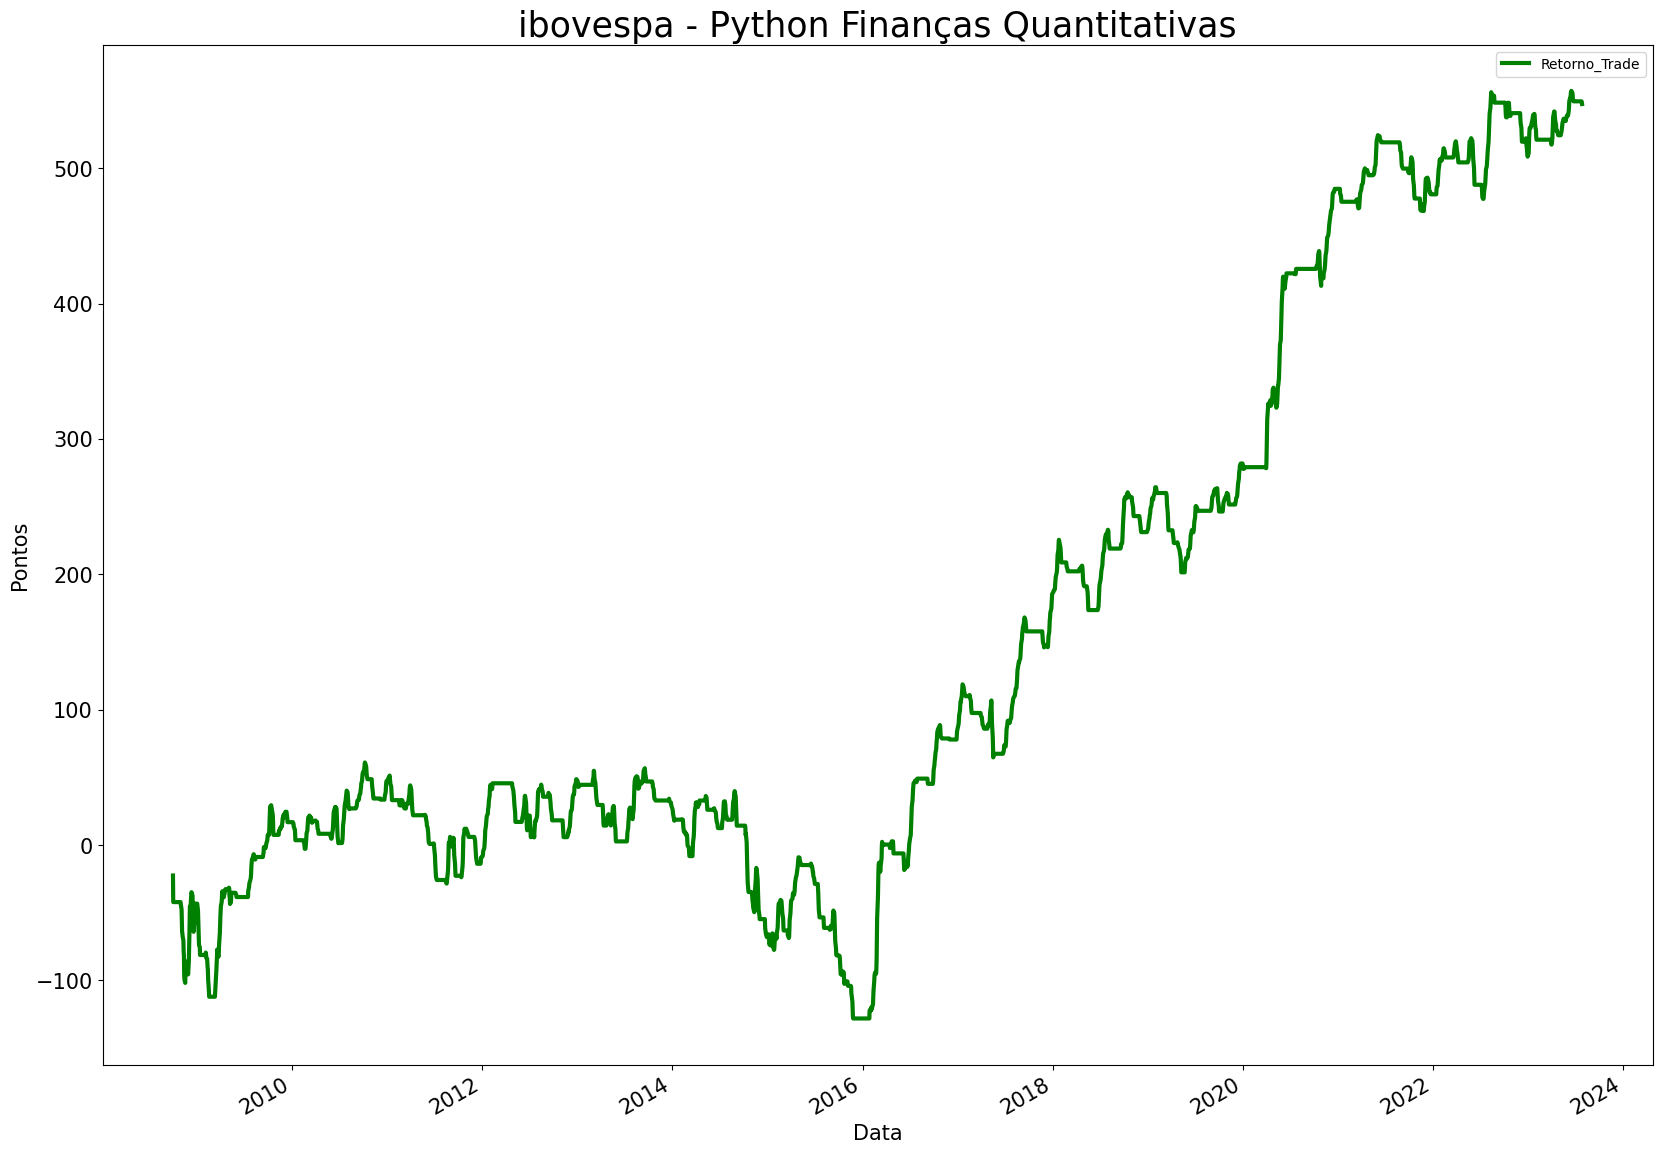

In [80]:
df_trix["Retorno_Trade"].plot(figsize=(20, 15), linewidth = 3, fontsize = 15, color = "green")
plt.xlabel("Data"
           , fontsize = 15);
plt.ylabel("Pontos"
           , fontsize = 15);
plt.title("ibovespa - Python Finanças Quantitativas"
           , fontsize = 25)
plt.legend();

In [71]:
def backtest_trix(df, trix_period, ma_period, periodos):
    # Certifique-se de que os dados estejam ordenados pela data crescente
    df = df.sort_index(ascending=True)
    
    # Calcular o TRIX e a média móvel do TRIX usando a biblioteca ta-lib
    close_prices = df['Adj Close'].values
    trix = ta.TRIX(close_prices, timeperiod=trix_period)
    trix_ma = ta.SMA(trix, timeperiod=ma_period)
    
    # Adicionar as colunas do TRIX e da média móvel do TRIX ao DataFrame
    df['TRIX'] = trix
    df['TRIX_MA'] = trix_ma
    
    # Calcular o retorno
    df['Retorno'] = df['Adj Close'].pct_change(periodos)
    df['Alvo'] = df['Retorno'].shift(-periodos)
    
    df = df.dropna(axis = 0) 

    # Criar a regra de trade
    df['Regra'] = np.where(df['TRIX'] > df['TRIX_MA'], 1, 0)
    
    # Aplicar a regra no alvo
    df['Trade'] = df['Regra'] * df['Alvo']*100
    
    # Calcular o resultado acumulado em juros simples
    df['Retorno_Trade'] = df['Trade'].cumsum()
    
    return df, df['Retorno_Trade'].iloc[-1]

In [78]:
# Exemplo de utilização:
trix_period = 14
ma_period = 3
periodos = 5
df_trix, retorno_backtest = backtest_trix(df, trix_period, ma_period, periodos)

In [79]:
retorno_backtest

547.344169775255

In [94]:
# Criar uma lista vazia para armazenar os resultados
results = []

# Definir o range de valores para cada parâmetro
trix_range = range(5, 10)   # Exemplo: de 10 a 28 com intervalo de 2
ma_range = range(3, 10)         # Exemplo: de 3 a 9
periodos_range = range(1, 5)   # Exemplo: de 3 a 10

# Loop para testar todas as combinações dos parâmetros e armazenar os resultados na lista
for trix_period in trix_range:
    for ma_period in ma_range:
        for periodos in periodos_range:
            _, retorno_backtest = backtest_trix(df, trix_period, ma_period, periodos)
            results.append({
                'trix_period': trix_period,
                'ma_period': ma_period,
                'periodos': periodos,
                'retorno_backtest': retorno_backtest
            })

# Criar um DataFrame a partir da lista de resultados
results_df = pd.DataFrame(results)

In [95]:
# Criar o gráfico interativo
fig = go.Figure(data=[go.Scatter3d(
    x=results_df['trix_period'],
    y=results_df['ma_period'],
    z=results_df['periodos'],
    mode='markers',
    marker=dict(
        size=10,
        color=results_df['retorno_backtest'],
        colorscale='Viridis',  # Escolha a escala de cores desejada
        colorbar=dict(title='Retorno Backtest')
    )
)])

# Configurar o layout do gráfico
fig.update_layout(
    scene=dict(
        xaxis_title='Trix Period',
        yaxis_title='MA Period',
        zaxis_title='Periodos'
    ),
    margin=dict(l=0, r=0, b=0, t=0),
)

# Exibir o gráfico interativo
fig.show()